# Imports
### General imports

In [2]:
import matplotlib.pyplot as plt
import pickle
import datetime as dt
import numpy as np
import pandas as pd

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Regressors imports

In [3]:
from sklearn.linear_model import LinearRegression as LM
from sklearn.linear_model import RidgeCV as Ridge
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neighbors import RadiusNeighborsRegressor as radNN
from sklearn.ensemble import ExtraTreesRegressor as ET
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as ANN

In [27]:
reg = {'LM':LM(),
      'Ridge':Ridge(),
      'KNN':KNN(),
#      'radNN':radNN(radius=200),
      'DT':DT(),
      'ET':ET(n_estimators=100, random_state=0),
      'SVM':SVR(),
      'ANN':ANN()}

### Assesment metrics

In [1]:
from sklearn.metrics import mean_squared_error, r2_score

# Data Loading

In [5]:
tsla_price = pickle.load(open("../data/data_h_corrected.pickle","rb"))['Open']
tsla_trend = pickle.load(open("../data/GT_tsla_h.pickle","rb"))
musk_trend = pickle.load(open("../data/GT_musk_h.pickle","rb"))

In [6]:
start_ts = tsla_price.index[0]
end_ts = tsla_price.index[-1]
tsla_trend = tsla_trend[start_ts:end_ts]
musk_trend = musk_trend[start_ts:end_ts]
data = pd.concat([tsla_price,tsla_trend,musk_trend],axis=1)
print(data.head(10))

                          Open  tsla  musk
2019-02-11 10:00:00  62.349998  1.62  3.36
2019-02-11 11:00:00  63.153004  2.61   3.5
2019-02-11 12:00:00  62.935997  4.23  3.64
2019-02-11 13:00:00  63.230000  5.49  3.71
2019-02-11 14:00:00  62.996002  8.46  3.92
2019-02-11 15:00:00  62.826836   9.0  4.13
2019-02-11 16:00:00  62.770000  7.92  4.34
2019-02-11 17:00:00        NaN  7.65  4.62
2019-02-11 18:00:00        NaN  7.74   4.9
2019-02-11 19:00:00        NaN  7.74  5.04


Note to self: there are only 7 hours of prices every working day, whereas there is trend data for every hour of every day... I should keep this in mind, and be wary as it might cause a problem later...

# Cut date for training/test set

In [7]:
cut_date = dt.datetime(year=2021,month=1,day=4,hour=10) # For now just testing various cut point around 2 month
print('cut date = ',cut_date)
#print(pd.Timestamp(cut_date))
#cut_idx = tsla_price.index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
#print('cut index = ',cut_idx)

cut date =  2021-01-04 10:00:00


# Auxilary functions
### Split data

In [8]:
def split_data(data,cut_idx):
    train = data[:cut_idx]
    test = data[cut_idx:]
    return train, test

### Converting from original to log returns and back functions

In [9]:
def convert_to_logret(stock_price):
    initial = stock_price.iloc[0]
    returns = 100*(np.log(stock_price)).diff()
    return returns, initial

def convert_from_logret(returns,initial):
    stock_price = np.exp((returns/100).cumsum()) * initial
    return stock_price

### Plot Prediction function

In [10]:
def plot_predict(stock_train,stock_test,stock_predict):
    fig, axs =plt.subplots(1,2,figsize=(20,5))

    axs[0].plot(stock_train)
    axs[0].plot(stock_test)
    axs[0].plot(stock_predict)

    axs[1].plot(stock_train[-300:])
    axs[1].plot(stock_test)
    axs[1].plot(stock_predict)
    return


#y_test_true = response[cut_idx:-35*4]
#x_test = features[cut_idx:-35*4]
#y_test = dectree_v2.predict(x_test)

#y_train_os = np.exp((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0]))
#offset = ((response[:cut_idx]/100).cumsum()+np.log(tsla['Open'].iloc[0])).iloc[-1,0]
#print(np.exp(offset))
#y_test_os = np.exp((y_test/100).cumsum(1)+offset)
#y_test_true_os = np.exp((y_test_true/100).cumsum(1)+offset)



# Features and responses

In [11]:
time = pd.Series(data=range(len(tsla_trend)),index=tsla_trend.index)
data['time'] = time
returns, initial = convert_to_logret(tsla_price)
data['returns'] = returns
print(data.head(20))
data.dropna(inplace=True)
print(data.head(20))

                          Open  tsla  musk  time   returns
2019-02-11 10:00:00  62.349998  1.62  3.36     0       NaN
2019-02-11 11:00:00  63.153004  2.61   3.5     1  1.279676
2019-02-11 12:00:00  62.935997  4.23  3.64     2 -0.344212
2019-02-11 13:00:00  63.230000  5.49  3.71     3  0.466058
2019-02-11 14:00:00  62.996002  8.46  3.92     4 -0.370760
2019-02-11 15:00:00  62.826836   9.0  4.13     5 -0.268897
2019-02-11 16:00:00  62.770000  7.92  4.34     6 -0.090504
2019-02-11 17:00:00        NaN  7.65  4.62     7       NaN
2019-02-11 18:00:00        NaN  7.74   4.9     8       NaN
2019-02-11 19:00:00        NaN  7.74  5.04     9       NaN
2019-02-11 20:00:00        NaN  7.92  5.53    10       NaN
2019-02-11 21:00:00        NaN  7.83  5.32    11       NaN
2019-02-11 22:00:00        NaN  6.48  5.74    12       NaN
2019-02-11 23:00:00        NaN  5.49  5.74    13       NaN
2019-02-12 00:00:00        NaN  4.86  5.46    14       NaN
2019-02-12 01:00:00        NaN  4.05  5.25    15       N

In [12]:
features = data[['tsla','musk','time']]
response = data[['returns']]
print(features)
print(response)

                      tsla   musk   time
2019-02-11 11:00:00   2.61    3.5      1
2019-02-11 12:00:00   4.23   3.64      2
2019-02-11 13:00:00   5.49   3.71      3
2019-02-11 14:00:00   8.46   3.92      4
2019-02-11 15:00:00    9.0   4.13      5
...                    ...    ...    ...
2021-02-10 11:00:00   9.36  11.52  17622
2021-02-10 12:00:00  12.24  12.48  17623
2021-02-10 13:00:00  14.76   12.8  17624
2021-02-10 14:00:00  20.88  12.48  17625
2021-02-10 15:00:00  29.88  22.72  17626

[3517 rows x 3 columns]
                      returns
2019-02-11 11:00:00  1.279676
2019-02-11 12:00:00 -0.344212
2019-02-11 13:00:00  0.466058
2019-02-11 14:00:00 -0.370760
2019-02-11 15:00:00 -0.268897
...                       ...
2021-02-10 11:00:00 -3.020245
2021-02-10 12:00:00 -0.525879
2021-02-10 13:00:00  0.033182
2021-02-10 14:00:00 -0.455639
2021-02-10 15:00:00 -0.065441

[3517 rows x 1 columns]


# training

In [13]:
#cut_idx = tsla_price.reset_index().index[tsla_price.index == pd.Timestamp(cut_date)].values[0]
cut_idx = pd.Timestamp(cut_date)
#print('cut index = ',cut_idx)

x_train, x_test = split_data(features,cut_idx)
y_train, y_test = split_data(response,cut_idx)
#print(x_train)
#print(x_test)
print(y_train)
#print(y_test)

                      returns
2019-02-11 11:00:00  1.279676
2019-02-11 12:00:00 -0.344212
2019-02-11 13:00:00  0.466058
2019-02-11 14:00:00 -0.370760
2019-02-11 15:00:00 -0.268897
...                       ...
2020-12-31 13:00:00 -0.054423
2020-12-31 14:00:00  0.026473
2020-12-31 15:00:00 -0.979709
2020-12-31 16:00:00 -1.436686
2021-01-04 10:00:00  2.999080

[3330 rows x 1 columns]


# fitting the models

In [28]:
#reg['LM'].fit(x_train,y_train)
for model in reg:
    reg[model].fit(x_train,y_train['returns'])

# Prediction

LM


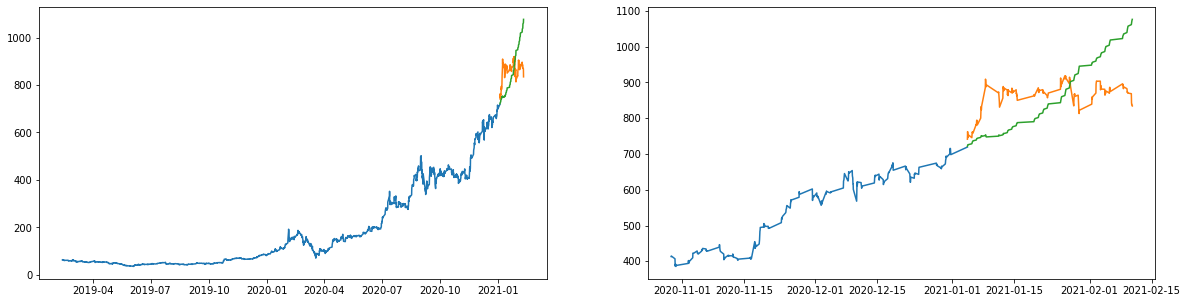

Ridge


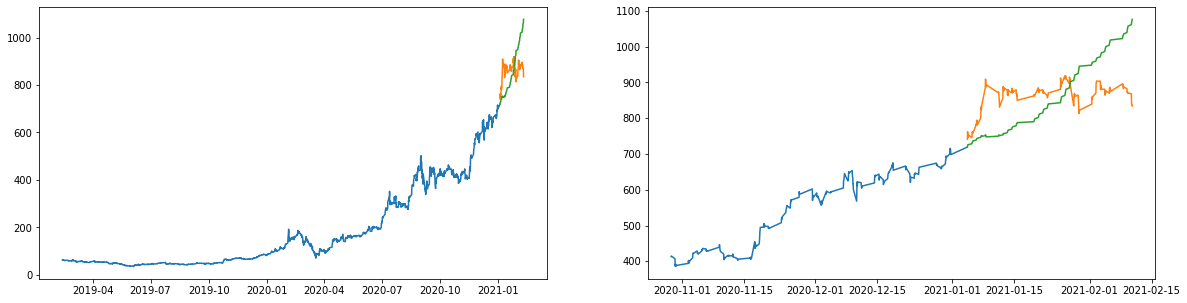

KNN


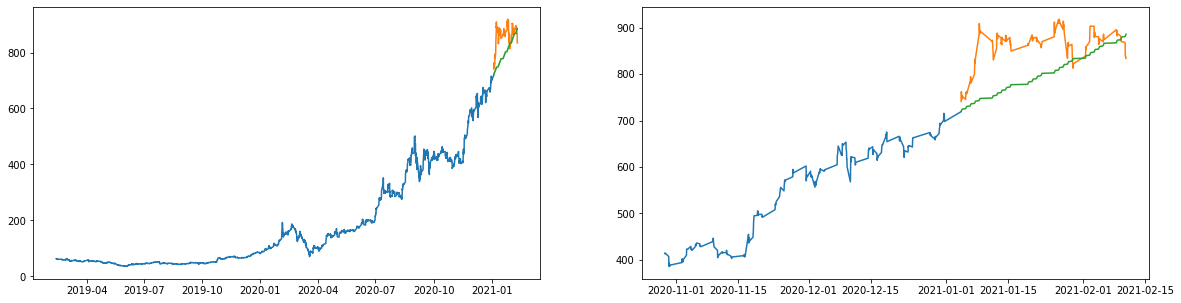

DT


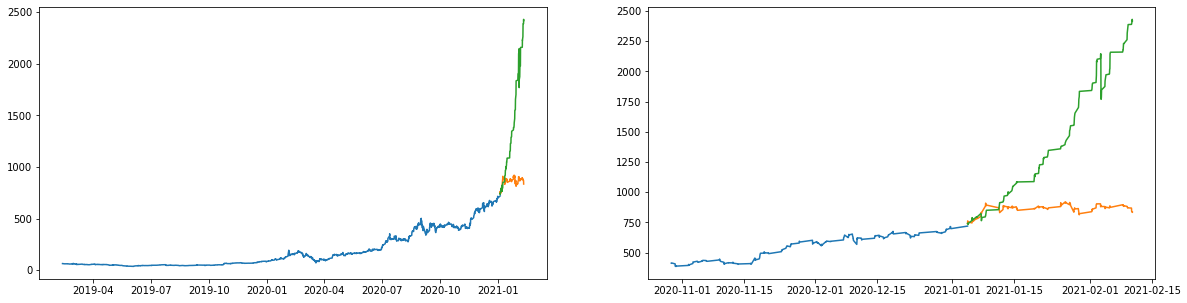

ET


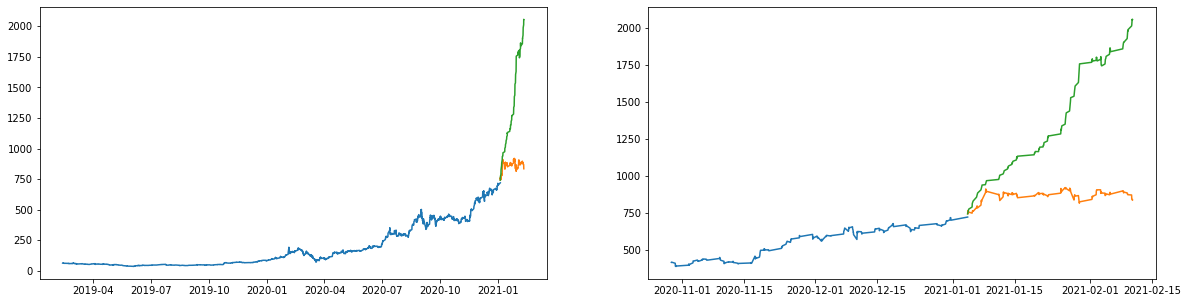

SVM


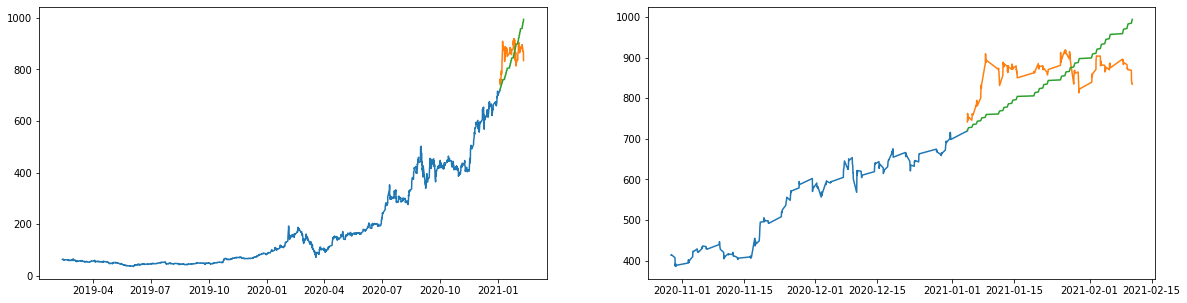

ANN


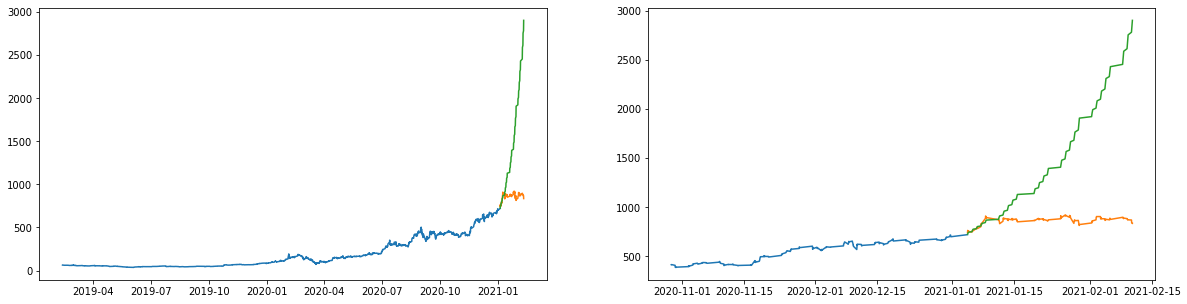

In [32]:
metrics = pd.DataFrame(index=reg.keys(),columns=["MSE","R2"])
for model in reg:
    print(model)
    y_predict = reg[model].predict(x_test)
    y_predict = pd.DataFrame(y_predict, index=x_test.index)
    y_train_os = convert_from_logret(y_train,initial)
    y_test_os = convert_from_logret(y_test,data.loc[cut_idx,'Open'])
    y_predict_os = convert_from_logret(y_predict,data['Open'][cut_idx])
    #plot_predict(y_train,y_test,y_predict)
    plot_predict(y_train_os,y_test_os,y_predict_os)
    plt.show()
    
    metrics["MSE"][model] = mean_squared_error(y_test, y_predict)
    metrics["R2"][model] = r2_score(y_test,y_predict)

# Assesment

In [33]:
print("mean square error : ",mean_squared_error(y_test, y_predict))
print("R2 : ",r2_score(y_test,y_predict))

print(metrics)

mean square error :  2.147055142698211
R2 :  -0.2903025798999388
            MSE        R2
LM     1.680698 -0.010039
Ridge  1.680696 -0.010038
KNN    1.665028 -0.000622
DT     5.474112 -2.289744
ET     2.153683 -0.294286
SVM    1.676797 -0.007694
ANN    2.147055 -0.290303
